# Train a DIP model

## Load Dataset

In [ ]:
! pip install datasets

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")


Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
from PIL import Image

def load_image(image_path, imsize):
    transform = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')  # Ensure the image is RGB
    image = transform(image).unsqueeze(0)
    return image

# to tensor
def preprocess(image):
    transform= transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),

    ])
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

# Simple convolutional neural network
class DeepImagePriorNet(nn.Module):
    def __init__(self):
        super(DeepImagePriorNet, self).__init__()

        # Define the layers of the model
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass through the model
        return self.layers(x)

# Function to add noise to an image
def add_noise(img, noise_factor=0.1):
    noisy_img = img + noise_factor * torch.randn(img.size())
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img

# Display function, tensor > numpy to show
def show_image(img):
    np_img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np_img)
    plt.show()

In [ ]:
# Load and display the original image
images = [preprocess(image) for image in dataset["image"]]
sample = images[0]
print('device: ', sample.shape)

device:  torch.Size([1, 3, 128, 128])


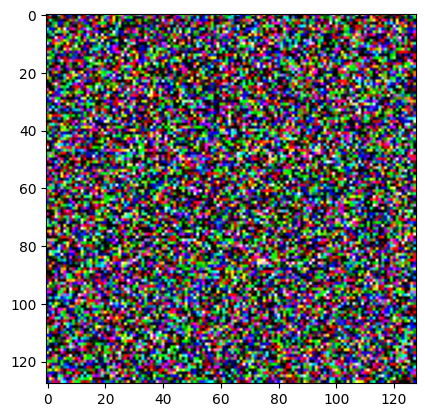

In [ ]:
# Add noise and display the noisy image
# noisy_img = add_noise(original_img)
# print('noisy image size:',noisy_img.size()) # torch size
# show_image(noisy_img)

# Initialize Deep Image Prior network
net = DeepImagePriorNet()

# Random noise input to the network
input_noise = torch.randn(sample.shape)
show_image(input_noise)

## Train DIP

In [ ]:
# Train DIP model for each image and generate initial priors
initial_priors = []

def train_dip_model(net,target):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), lr=0.01)
  # Training the network
  num_iter = 200
  for i in range(num_iter):
      optimizer.zero_grad()
      output = net(input_noise)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      # if i == 199:
            # print(f'Iteration {i}, Loss: {loss.item()}')
  return output.detach()

noise = torch.randn(sample.size()).to(sample.device)

for i in range (450):
  if i > 399:
    print(i)
    net = DeepImagePriorNet()
    initial_prior = train_dip_model(net,images[i])
    initial_priors.append(initial_prior)
  # show_image(initial_prior)
# 400-449

50


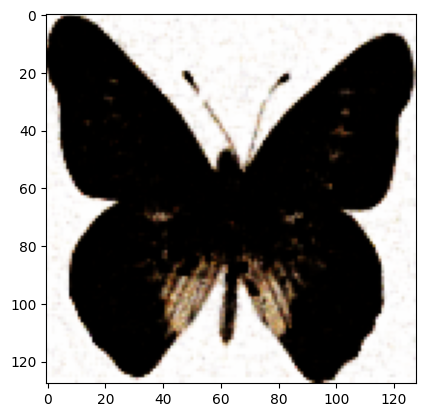

In [ ]:
print(len(initial_priors))
show_image(initial_priors[0])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
initial_prior_path = '/content/drive/MyDrive/GAI_HW4/'
# Convert the tensor to a NumPy array


import matplotlib.pyplot as plt

for i in range(50):
    numpy_image = initial_priors[i].squeeze(0).permute(1, 2, 0).numpy()
    path = initial_prior_path + f"{i+400:03}" + '.png'
    print(path)
    plt.imsave(path, numpy_image)


In [ ]:
len(initial_priors)

50

# Train a diffusion model

## Training configuration

In [ ]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers[training]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 25.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    # push_to_hub = False  # whether to upload the saved model to the HF Hub
    # hub_private_repo = False
    # overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Load the dataset

In [ ]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")
dataset = dataset.select(range(100))

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
for step, batch in enumerate(train_dataloader):
    clean_images = batch['images']
    print(clean_images[0].shape)
    print(clean_images.shape)
    print(clean_images.device)
    break

torch.Size([3, 128, 128])
torch.Size([16, 3, 128, 128])
cpu


## Load Initial Priors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

initial_prior_path = '/content/drive/MyDrive/GAI_HW4/'
file_list = os.listdir(initial_prior_path)
initial_priors = []

for file_name in file_list:
  image_path = os.path.join(initial_prior_path, file_name)
  image = Image.open(image_path)
  initial_priors.append(image)


In [ ]:
initial_priors = [preprocess(image.convert("RGB")) for image in initial_priors]

In [ ]:
print('datasize:',len(initial_priors))
initial_priors[0].shape

datasize: 500


torch.Size([1, 3, 128, 128])

In [ ]:
dataset = [initial_prior.squeeze(0) for initial_prior in initial_priors]
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for step, batch in enumerate(train_dataloader):
    # clean_images = batch['images']
    clean_images = batch
    print(clean_images[0].shape)
    print(clean_images.shape)
    print(clean_images.device)
    break

## Create a UNet2DModel

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


It is often a good idea to quickly check the sample image shape matches the model output shape:

Input shape: torch.Size([1, 3, 128, 128])


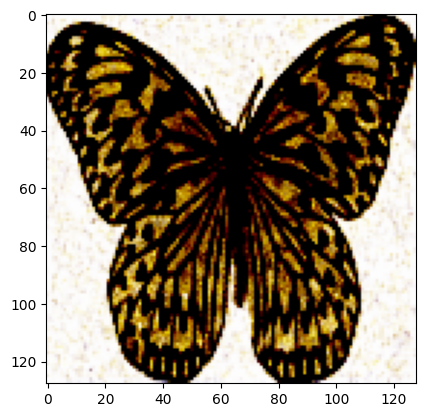

In [ ]:
dataset = initial_priors
# sample_image = dataset[0]
# sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
show_image(sample_image)

## Create a scheduler

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=500,beta_schedule="linear")
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
print(noisy_image.device)

cpu


In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample # tensor
loss = F.mse_loss(noise_pred, noise)

def show_tensor(img):
  # # Remove the batch dimension (assuming batch size is 1)
  image = img.squeeze(0)
  # # Convert the tensor to a PIL image
  to_pil = transforms.ToPILImage()
  image = to_pil(image)
  display(image)


# show_tensor(noisy_image)


## Train the model

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
from diffusers import DDPMPipeline
import math
import os

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F
import os
import time

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    start_time = time.time()
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            ### without DIP
            # clean_images = batch["images"]

            ### DIP
            clean_images = batch

            noise =  torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):

                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")


In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

Once training is complete, take a look at the final 🦋 images 🦋 generated by your diffusion model!

  0%|          | 0/500 [00:00<?, ?it/s]

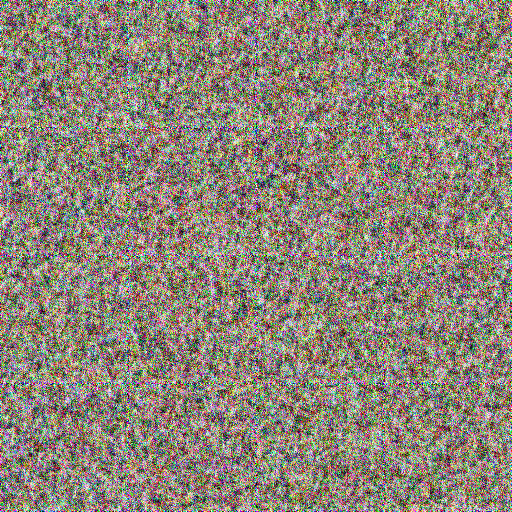

In [ ]:
accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        num_inference_steps=500,
    ).images
image_grid = make_grid(images, rows=4, cols=4)
image_grid

## Evalution

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity

def calculate_psnr(original_image, reconstructed_image):
    psnr = peak_signal_noise_ratio(original_image, reconstructed_image)
    return round(psnr,3)

def calculate_ssim(original_image, reconstructed_image):
    ssim, _ = structural_similarity(original_image, reconstructed_image, full=True, multichannel=True)
    return round(ssim,3)

In [ ]:
# input = dataset[0]['images'].permute(1, 2, 0).numpy()

total_psnr = 0
total_ssim = 0
for image in images:
  # PIL(size) to numpy(shape)
  output = np.array(image)/255
  single_psnr = 0
  single_ssim = 0
  for i in range(16):
    # tensor to a NumPy array
    # Transpose from (C, H, W) to (H, W, C)
    input = dataset[i]['images'].squeeze(0)
    input = input.permute(1, 2, 0).numpy()
    # input = dataset[i].squeeze(0).permute(1,2,0).numpy()
    psnr = calculate_psnr(input,output)
    ssim = calculate_ssim(input,output)
    single_psnr += psnr
    single_ssim += ssim
  print('SINGLE PSNR: ',single_psnr/16,'SINGLE SSIM: ', single_ssim/16)
  total_psnr += single_psnr/16
  total_ssim += single_ssim/16
print('PSNR:',round(total_psnr/16,3))
print('SSIM:',round(total_ssim/16,3))

SINGLE PSNR:  7.013625000000002 SINGLE SSIM:  0.00043749982432927936
SINGLE PSNR:  6.99375 SINGLE SSIM:  0.0002500000409781933
SINGLE PSNR:  6.973875 SINGLE SSIM:  0.0005624997575068846
SINGLE PSNR:  7.0395 SINGLE SSIM:  0.0013750001235166565
SINGLE PSNR:  6.946937500000001 SINGLE SSIM:  6.249993748497218e-05
SINGLE PSNR:  6.959312499999999 SINGLE SSIM:  6.249990838114172e-05
SINGLE PSNR:  6.988374999999999 SINGLE SSIM:  0.00012500007142079994
SINGLE PSNR:  6.997 SINGLE SSIM:  0.00043750001350417733
SINGLE PSNR:  6.9614375 SINGLE SSIM:  0.0012499999938881956
SINGLE PSNR:  6.975499999999999 SINGLE SSIM:  -0.00037500003236345947
SINGLE PSNR:  6.9588125 SINGLE SSIM:  -0.0012499998847488314
SINGLE PSNR:  6.975875000000001 SINGLE SSIM:  0.000624999993306119
SINGLE PSNR:  6.9773125 SINGLE SSIM:  -0.00018749998707789928
SINGLE PSNR:  6.9544999999999995 SINGLE SSIM:  -0.00012499995500547811
SINGLE PSNR:  6.9679375 SINGLE SSIM:  0.0003749999596038833
SINGLE PSNR:  6.972625 SINGLE SSIM:  -0.0008